In [47]:
# Autoreload all modules
%load_ext autoreload
%autoreload 2

import numpy as np
import jax
import jax.numpy as jnp
import jax.random as jr
import pylab as plt

# add ../mcjax to the path
import sys
sys.path.append('../../')

from mcjax.proba.banana2d import Banana2D
from mcjax.mcmc.mala import MALAKernel
from mcjax.util.plot_2d import evaluate_on_grid_2d


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [48]:
# initialize jax RNG
key = jr.key(0)

### 2D Banana

In [ ]:
dist = Banana2D.create()
params_banana = dist.init_params(noise_std=0.2)
log_prob = dist.log_prob_only(params=params_banana)
log_prob_batch = jax.vmap(log_prob)

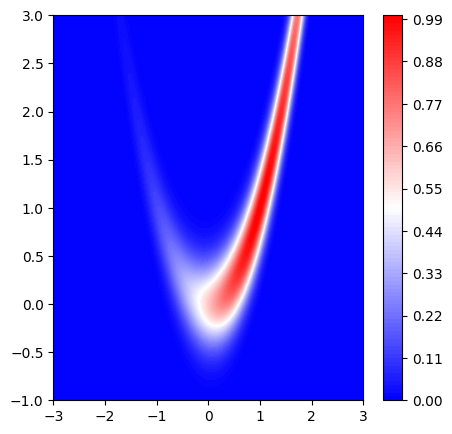

In [50]:
xmin, xmax = -3, 3
ymin, ymax = -1, 3
X, Y, Z = evaluate_on_grid_2d(
    func_batch=log_prob_batch,
    xlim=(xmin, xmax),
    ylim=(ymin, ymax),
    Nx=500,
    Ny=500
)

# plot the logpdf
plt.figure(figsize=(5, 5))
plt.contourf(X, Y, jnp.exp(Z), 100, cmap='bwr', origin='lower')
plt.colorbar()
plt.show()


## Run Mala

In [51]:
# Create MALA kernel instance
kernel = MALAKernel.create(log_prob=log_prob, cov_type="diag")

# Initialize parameters and state
x_init = jnp.array([0.0, 0.0])
params = kernel.init_params(x_init, step_size=0.05)  # cov defaults to identity
state = kernel.init_state(x_init)

# Run MCMC
n_samples = 10_000
mcmc_output = kernel.run_mcmc(
    initial_state=state,
    params=params,
    key=key,
    n_samples=n_samples,
)

In [52]:
traj = mcmc_output.traj 
summary = mcmc_output.summary

(-1.0, 3.0)

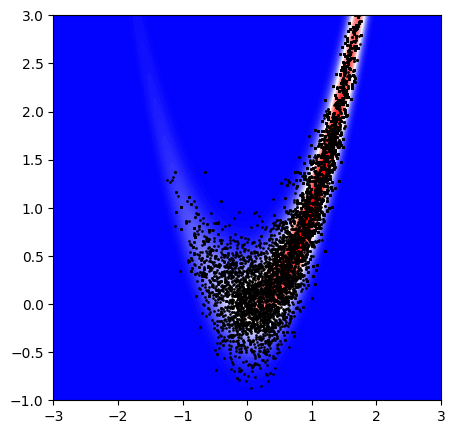

In [53]:
samples = traj.x
# scatter plot of the samples
plt.figure(figsize=(5, 5))
plt.contourf(X, Y, jnp.exp(Z), 100, cmap='bwr', origin='lower')
plt.scatter(samples[:, 0], samples[:, 1], s=1, color='black', alpha=0.9)
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)

In [54]:
acceptance_rate = summary.acceptance_rate
print(f"Acceptance rate: {100*acceptance_rate:.2f}%")

Acceptance rate: 38.85%


## Influence of epsilon on the acceptance rate

In [55]:
# Define a function that samples a trajectory using MALA
def sample_MALA(key, x0, step_size, n_steps):
    # Create the MALA kernel (static, JIT-safe)
    kernel = MALAKernel.create(log_prob=log_prob, cov_type="full")

    # Initialize parameters and state
    params = kernel.init_params(x0, step_size=step_size, cov=jnp.eye(x0.shape[-1]))
    state = kernel.init_state(x0)

    # Run MCMC
    mcmc_output = kernel.run_mcmc(
        initial_state=state,
        params=params,
        key=key,
        n_samples=n_steps
    )
    return mcmc_output

# JIT compile the sampler for a single trajectory
sample_MALA = jax.jit(sample_MALA, static_argnums=(3,))

# Define a batched version over multiple step sizes
sample_MALA_batch = jax.jit(
    jax.vmap(sample_MALA, in_axes=(None, None, 0, None)),
    static_argnums=(3,)
)

In [56]:
epsilon_arr = 10**np.linspace(-3, 0, 200)
n_steps = 500_000
key, key_ = jr.split(key)
x0 = jnp.array([0., 0.])
mcmc_output_batch = sample_MALA_batch(key_, x0, epsilon_arr, n_steps)
traj_batch = mcmc_output_batch.traj
summary_batch = mcmc_output_batch.summary

Text(0.6, 0.6, 'Optimal step size: 0.10 \n Acceptance rate: 0.27')

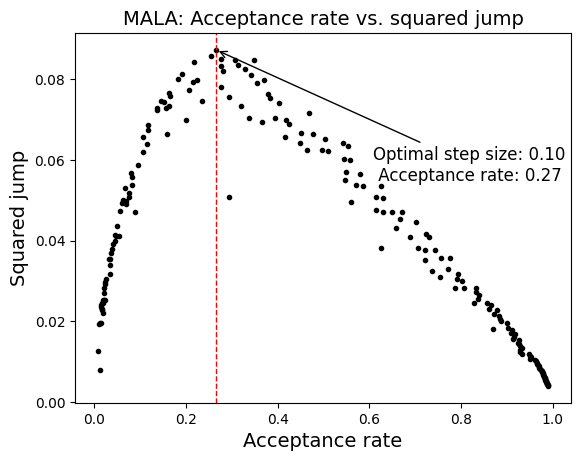

In [57]:
plt.plot(summary_batch.acceptance_rate, summary_batch.sq_jump, ".", color='black')
plt.xlabel("Acceptance rate", fontsize=14)
plt.ylabel("Squared jump", fontsize=14)
plt.title("MALA: Acceptance rate vs. squared jump", fontsize=14)

# find the optimal step size by maximizing the squared jump
index_opt = np.argmax(summary_batch.sq_jump)
optimal_step_size = epsilon_arr[index_opt]
optimal_acceptance_rate = summary_batch.acceptance_rate[index_opt]
optimal_sq_jump = summary_batch.sq_jump[index_opt]

# draw vertical line at the optimal step size
plt.axvline(optimal_acceptance_rate, color='red', lw=1, ls='--')
# add an arrow pointing to the optimal step size with the value
plt.annotate(f"Optimal step size: {optimal_step_size:.2f} \n Acceptance rate: {optimal_acceptance_rate:.2f}",
                xy=(optimal_acceptance_rate, optimal_sq_jump),
                xytext=(0.6, 0.6),
                textcoords='axes fraction',
                arrowprops=dict(facecolor='red', arrowstyle="->"),
                fontsize=12)